# Report

I declare that I have worked on this assessment independently.

## Author: Fortunato Nucera

This file contains the code relative to the report for the final coursework of Unstructured Data Analysis. 
In this notebook we will attempt a comparison between various techniques for gray-scale image denoising.
Given the limiting maximum size of the allowed data set (100MB), we faced a trade-off between the interest in 
the data type (colored images) and the amount of data to be used for training. As gray-scale images use $1$ channel instead of $3$, 
they are suitable to be used in the current context.

This notebook will feature the following techniques for denoising:

1. **Spatial Noise Filters**:
    1. Mean Filter
    1. Median Filter
    1. Minimum Filter
    1. Maximum Filter


2. **Non-local Means denoising** as described [in this paper](https://docs.google.com/viewerng/viewer?url=https://www.ipol.im/pub/art/2011/bcm_nlm//article_lr.pdf).

3. **Denoising via dimensionality reduction techniques**:
    1. Principal Component Analysis (PCA)
    1. Non Negative Matrix Factorization (NMF)

4. **Deep Learning technique**: `U-Net`

Each of the methods will have some nuts and bolts to be fine-tuned. These will also be covered in the report. In particular, 
for the purpose of the training, we will employ a Huber Loss which we will need to minimize. This metric will be evaluated 
in the exact same way across the entire range of covered methods. Since the Huber Loss was not covered in the notes, 
we will briefly describe the fundamental concept here and include it in the final report as well.

Given three numbers $x,y, \epsilon \in \mathbb{R}$, the Huber Loss is defined as follows:
$$\mathcal{L}_{\textrm{Huber}}(x,y)=\begin{cases}
0.5 (x-y)^2 & \textrm{ if } |x-y|<\epsilon \\
\epsilon (|x-y|-0.5\epsilon) & \textrm{otherwise}
\end{cases}
$$
$\epsilon$ is an arbitrary small value, which sets the location of the switchpoint between the quadratic and the linear function. 
If the images are normalized in the $[0,1]$ interval, its value can be reasonably set in the same interval. Here we choose $\epsilon=0.2$.
For vectors $\mathbf{v} \in \mathbb{R}^d$, the Huber Loss can also be defined via the application of a reduction function $f(\cdot)$ that is 
a map $\mathbb{R}^d \to \mathbb{R}$, which is usually either the sum or the mean of the input values. In other words, if we let $\mathbf{x},\mathbf{y} \in \mathbb{R}^d$ and $\epsilon \in \mathbb{R}$, then $\mathcal{L}_{\textrm{Huber}}(\mathbf{x},\mathbf{y}) = f \left(\mathcal{L}_{\textrm{Huber}}(x_1,y_1), \dots, \mathcal{L}_{\textrm{Huber}}(x_d,y_d) \right)$.
Note that all the preliminary conclusions will be drawn on the training set, which will be defined at the beginning of the notebook. This is done in order to prevent any data leakage.

First of all, we load in all the relevant libraries.

In [1]:
### Data Libraries
import pyarrow.parquet as pq

### Computing Libraries
import numpy as np
import pandas as pd

### Viz libraries
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["text.usetex"] = True # set this to False if LaTex is not available on your machine

### CV Libraries
from skimage.filters.rank import minimum, maximum, mean, median
import cv2
from PIL import Image, ImageDraw, ImageFont
from torchvision.transforms import transforms

### DL Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchinfo import summary

### Seeds
CID = 2165798
np.random.seed(CID)
torch.manual_seed(CID)

### Others
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import tqdm
    
### Multi-core processing
from joblib import Parallel, delayed
import os

### Generate folder to save graphs in
os.makedirs("graphs", exist_ok=True)

### Generals
from collections import Counter
from PyPDF2 import PdfMerger
from natsort import natsorted
import glob

Some notes on the figures of the report. Most of the pictures included in the report have been created via this script. We will add a comment on top of each relevant image export command to indicate which figure the image belongs to. For some pictures, there is not a corresponding command that has been used, as images may have been assembled in an external software, like Adobe Photoshop or Microsoft Power Point. The exceptions are below:
- Figure 1 has been created in Photoshop
- Figure 2 has been assembled in Power Point.
- Figure 4, 5, 6, 7, 9, 10, 11, 13 are a Power Point assembly of pictures generated in the current notebook, mainly in Section 6.
- Figure 8 has been created using http://alexlenail.me/NN-SVG/AlexNet.html and Power Point

## 0. Data set preparation

In this section, we will prepare the data set for processing. The images are summarized in a parquet data frame, where each column represents one image.

In [2]:
dataset = pq.read_table('dataset.parquet').to_pandas()
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Columns: 4050 entries, i_0 to i_4049
dtypes: uint8(4050)
memory usage: 126.6 MB


,i_0,i_1,i_2,i_3,i_4,i_5,i_6,i_7,i_8,i_9,...,i_4040,i_4041,i_4042,i_4043,i_4044,i_4045,i_4046,i_4047,i_4048,i_4049
0,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
1,92,215,190,240,88,134,60,144,20,50,...,29,25,29,139,50,20,137,116,154,205
2,83,219,190,246,110,136,43,140,18,39,...,14,19,29,148,47,15,117,129,189,218
3,92,221,171,250,125,162,43,130,16,42,...,22,20,31,149,54,17,106,111,183,217
4,78,222,188,240,160,134,58,143,19,22,...,24,24,33,155,54,19,127,92,215,208


Each column of the dataframe df contains, in order:
- an encoding representing the camera the picture was taken with
- a noisy input image
- a noise-free target image

In particular, we set the following encoding for the camera type:
<br>
0 : Xiaomi Mi3 <br>
1 : Canon T3i <br>
2 : Canon S90 <br>

As a result, there are in total `4050` (number of columns) images and each image includes `128x128=16384` pixels. `16384 pixel/image * 2 images + 1 camera encoding = 32769 rows`. The dimensions match perfectly!

We split the data set into training set (`df_training_set`) and test set (`df_test_set`).

In [3]:
classIndices = np.stack((np.random.permutation(np.where(dataset.iloc[0,:].values==0)[0]),
                         np.random.permutation(np.where(dataset.iloc[0,:].values==1)[0]),
                         np.random.permutation(np.where(dataset.iloc[0,:].values==2)[0])))

trainTestSplit = 0.9 # keeep 90% in training set and 10% in test set

train_idx = classIndices[:,:int(classIndices.shape[1]*trainTestSplit)].flatten()
test_idx = classIndices[:,int(classIndices.shape[1]*trainTestSplit):].flatten()

print(f"There are {len(train_idx)} images in the training set")
print(f"There are {len(test_idx)} images in the test set")
print(f"Is there any data leakage? {len((set(train_idx).intersection(set(test_idx))))!=0}")

### Training and test set
df_training_set = dataset.iloc[:,train_idx]
df_test_set = dataset.iloc[:,test_idx]

There are 3645 images in the training set
There are 405 images in the test set
Is there any data leakage? False


Then, we shuffle the test set, and split into 90% (machine evaluation) and 10% (human evaluation - the meaning of this is explained in the report and in section 5. of the present notebook). In particular, since the images come from 3 different cameras, we want to perform stratified sampling in order to obtain equal proportions of the pictures for a given camera across both machine and human set.

In [4]:
### 0. count the number of instances for each class in the test set
count = Counter(df_test_set.iloc[0,:].values)
print(f"Number of instances in the test set: {count}")

### 1. Shuffle the test set
df_test_test_shuffled = df_test_set.iloc[:,np.random.permutation(df_test_set.shape[1])]

### 2. pick 15 images from each class for human set and the remainder for machine set
humanPics = 15
humanSet = []
machineSet = []

### 3. obtain the indices
for i in range(3):
    class_indices = np.where(df_test_test_shuffled.iloc[0,:]==i)[0].tolist()
    humanSet += class_indices[:humanPics]
    machineSet += class_indices[humanPics:]
    
### 4. extract the sets
humanSet = df_test_test_shuffled.iloc[:,humanSet]
machineSet = df_test_test_shuffled.iloc[:,machineSet]

Number of instances in the test set: Counter({0: 135, 1: 135, 2: 135})


We also define a helper function which takes in an index for the column in the dataset, and generates the input and the target image. We use this function when processing the images. Note that the output is a `float` image where the range is between $0$ and $1$.

In [5]:
def dfId2Pics(data,i, sizes=(128,128)):
    """
    Takes in a data frame and an index and returns a pair of pictures (float, 0-1 scale).
    The first picture of the pair is the noisy input. The second picture is the target.
    Inputs:
    - data: data frame containing the pictures
    - i   : the index
    - sizes : the number of rows and columns of the picture
    Outputs:
    - out : a tuple of noisy image and target image
    """
    img_1 = data.iloc[1:,i].values[:np.prod(sizes)].reshape(sizes)/255.0
    img_2 = data.iloc[1:,i].values[np.prod(sizes):].reshape(sizes)/255.0
    return (img_1,img_2)

This completes the data preparation.

# 1. Spatial Noise Filters

Given a mask $W$ of size $m \times n$ and an image $f(x,y)$ of size $M \times N$, a spatial noise filter assigns a function over the mask $W$ centered at $x,y$ to the pixel $x,y$ in the new image $f_{new}(x,y)$. For example:  

* **Mean Filter**:
$f_{new}(x,y) = \frac{1}{mn} \sum_{a=1}^M \sum_{b=1}^N \mathbb{1}_{W}(a,b) f(a,b)$
* **Median Filter**: 
$f_{new}(x,y) = \textrm{median}(\mathbb{1}_{W}f(x,y))$
* **Maximum Filter**: 
$f_{new}(x,y) = \textrm{max}(\mathbb{1}_{W}f(x,y))$
* **Minimum Filter**: 
$f_{new}(x,y) = \textrm{minimum}(\mathbb{1}_{W}f(x,y))$

The problem is then reduced to establishing the value of the parameter $m$ and $n$ of the mask $W$ which better perform on a given image. Since we have a training set, we may consider using that to establish which filter size brings, in general, good results on the data set, via the definition of a loss function.  We will here impose two constraints:
- The window used for filtering is "squared" in size $\implies m=n$
- The minimum window size will be set to 1 and the maximum window size will be set to 11 (these are the search boundaries).

The loss mentioned above will be assumed to be in the form of a Huber Loss, whose evaluation is included below:

In [6]:
def HuberLoss(x,y, epsilon=0.2, reduction="mean"):
    """
    Calculates the Huber Loss between two arrays x and y
    Inputs:
    - x : np.ndarray, first image
    - y : np.ndarray, second image
    - epsilon : the value of epsilon to switch losses
    - reduction : "mean" or "sum" depending on the preferred methodology
    Output:
    - out : float, the Huber Loss Value
    """
    ### calculate the mask to establish where to use the quadratic function and where to use the linear one
    mask = np.abs(x-y) < epsilon
    
    ### calculate the huber loss
    out = mask*0.5*(x-y)**2.0 + (1.0-mask)*epsilon*(np.abs(x-y)-0.5*epsilon)
    
    if reduction == "mean":
        return out.mean()
    elif reduction == "sum":
        return out.sum()
    else:
        ValueError("Reduction can only be 'mean' or 'sum'")

We choose the value for the threshold $\epsilon=0.2$ as the range of the images is $[0,1]$.

## 1.1 Mean Filter

We will here calculated the optimal size for the mean filter.

  0%|          | 0/3645 [00:00<?, ?it/s]

  0%|          | 0/3645 [00:00<?, ?it/s]

Most common 'good' window size for Mean filter is 3, with a loss of 0.00030014945900786453


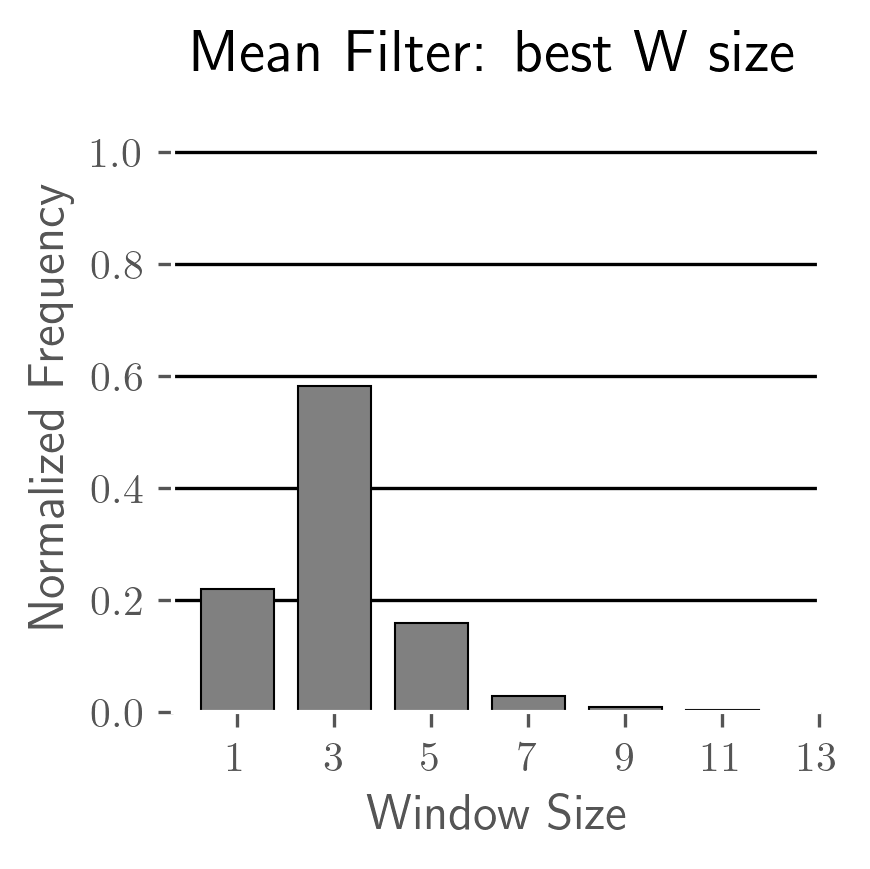

In [7]:
## set the image size
size = 128
## set window sizes
ws = np.arange(1,12,2)
## define a filterFunc lambda function to wrap the skimage function
filterFunc = lambda inputImg, fSize: mean(inputImg, footprint=np.ones((fSize,fSize)))

### calculate best mean filter 
best_size_mean = np.zeros(df_training_set.shape[1])
for i in tqdm.notebook.tqdm(range(df_training_set.shape[1])):
    ## pick the images from the set
    img_input, img_target = dfId2Pics(df_training_set,i, sizes=(128,128))
    ## we need uint8 pictures
    img_input, img_target = (img_input*255.0).astype(np.uint8), (img_target*255.0).astype(np.uint8)
    
    best_size_on_image = np.zeros(ws.shape[0])
    ## loop on the window sizes
    for wid,j in enumerate(ws):
        best_size_on_image[wid]=HuberLoss(img_target/255.0, filterFunc(img_input, j)/255.0, reduction="mean")
    best_size_mean[i] = ws[np.argmin(best_size_on_image)]
    
### good window size
proper_window_size = np.argmax(np.bincount(best_size_mean.astype(int))) 

loss = 0
### loop over all pictures and filter with this window size, to get a correct estimate of the loss
for i in tqdm.notebook.tqdm(range(df_training_set.shape[1])):
    ## pick the images from the set
    img_input, img_target = dfId2Pics(df_training_set,i, sizes=(128,128))
    ## we need uint8 pictures
    img_input, img_target = (img_input*255.0).astype(np.uint8), (img_target*255.0).astype(np.uint8)
    
    loss += HuberLoss(img_target/255.0, filterFunc(img_input, proper_window_size)/255.0, reduction="mean")

### normalize loss
loss /= i

### group values together
best_size_mean_cut = np.array(sorted([[int(key), float(val)/df_training_set.shape[1]]for key, val in Counter(best_size_mean).items()], key=lambda x : x[0]))

### plot results
plt.figure(figsize=(3,3), dpi=300)
plt.bar(best_size_mean_cut[:,0], best_size_mean_cut[:,1], edgecolor="k", facecolor="gray", width=1.5)
plt.xticks(np.arange(1,14,2))
plt.title("Mean Filter: best W size")
plt.ylim(0,1.1);
print(f"Most common 'good' window size for Mean filter is {proper_window_size}, with a loss of {loss}")
plt.grid(c="black", axis="y");
plt.xlabel("Window Size"); plt.ylabel("Normalized Frequency")
plt.tight_layout()
### Figure 10, first from left
plt.savefig("./graphs/000_mean_filter_graph.png")

From the graph we deduce that, for the mean filter, the window size achieving best results is $m=n=3$.

## 1.2 Median Filter

We proceed with the same function. We include the code here again for completeness. The only thing we modify is the `filterFunc` function, which now wraps the median filter instead of the mean one.

  0%|          | 0/3645 [00:00<?, ?it/s]

  0%|          | 0/3645 [00:00<?, ?it/s]

Most common 'good' window size for Median filter is 3, with a loss of 0.00027886586213114793


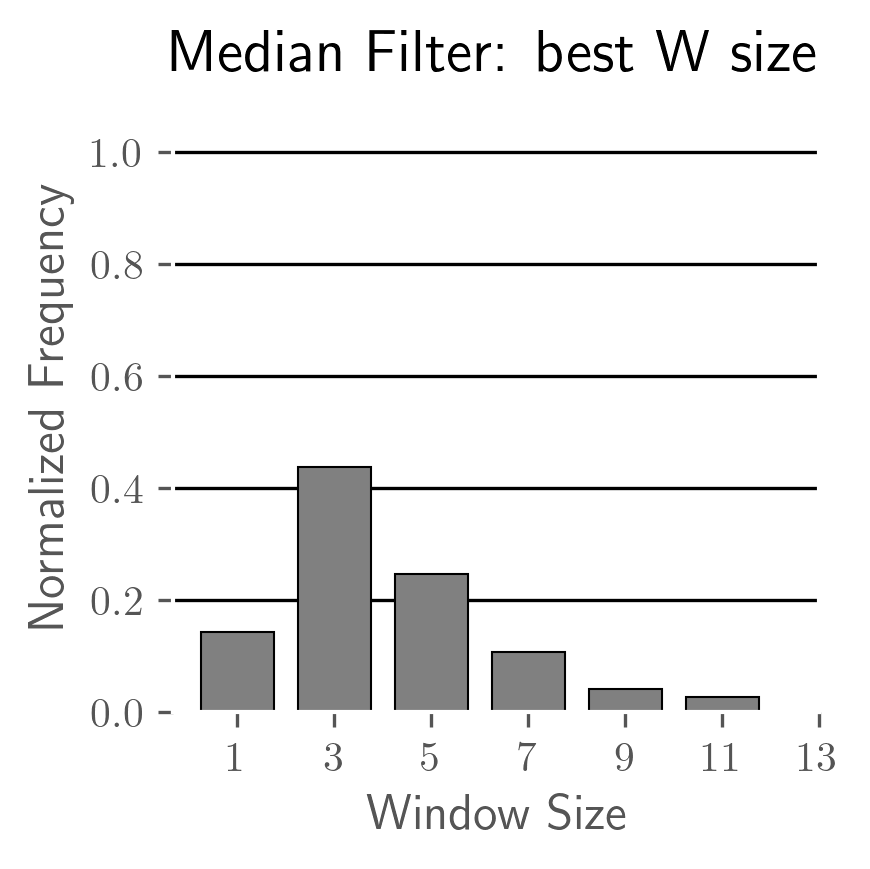

In [8]:
## set the image size
size = 128
## set window sizes
ws = np.arange(1,12,2)
## define a filterFunc lambda function to wrap the skimage function
filterFunc = lambda inputImg, fSize: median(inputImg, footprint=np.ones((fSize,fSize)))

### calculate best median filter 
best_size_median = np.zeros(df_training_set.shape[1])
for i in tqdm.notebook.tqdm(range(df_training_set.shape[1])):
    ## pick the images from the set
    img_input, img_target = dfId2Pics(df_training_set,i, sizes=(128,128))
    ## we need uint8 pictures
    img_input, img_target = (img_input*255.0).astype(np.uint8), (img_target*255.0).astype(np.uint8)
    
    best_size_on_image = np.zeros(ws.shape[0])
    ## loop on the window sizes
    for wid,j in enumerate(ws):
        best_size_on_image[wid]=HuberLoss(img_target/255.0, filterFunc(img_input, j)/255.0, reduction="mean")
    best_size_median[i] = ws[np.argmin(best_size_on_image)]

### good window size
proper_window_size = np.argmax(np.bincount(best_size_median.astype(int))) 

loss = 0
### loop over all pictures and filter with this window size, to get a correct estimate of the loss
for i in tqdm.notebook.tqdm(range(df_training_set.shape[1])):
    ## pick the images from the set
    img_input, img_target = dfId2Pics(df_training_set,i, sizes=(128,128))
    ## we need uint8 pictures
    img_input, img_target = (img_input*255.0).astype(np.uint8), (img_target*255.0).astype(np.uint8)
    
    loss += HuberLoss(img_target/255.0, filterFunc(img_input, proper_window_size)/255.0, reduction="mean")

### normalize loss
loss /= i

### group values together
best_size_median_cut = np.array(sorted([[int(key), float(val)/df_training_set.shape[1]]for key, val in Counter(best_size_median).items()], key=lambda x : x[0]))

### plot results
plt.figure(figsize=(3,3), dpi=300)
plt.bar(best_size_median_cut[:,0], best_size_median_cut[:,1], edgecolor="k", facecolor="gray", width=1.5)
plt.xticks(np.arange(1,14,2))
plt.title("Median Filter: best W size")
plt.ylim(0,1.1);
print(f"Most common 'good' window size for Median filter is {proper_window_size}, with a loss of {loss}")
plt.grid(c="black", axis="y");
plt.xlabel("Window Size"); plt.ylabel("Normalized Frequency")
plt.tight_layout()
### Figure 10, second from left
plt.savefig("./graphs/001_median_filter_graph.png")

Again, for the median filter, the best results are achieved for a window size of 3.

## 1.3 Maximum Filter

We proceed with the same function. We include the code here again for completeness. The only thing we modify is the `filterFunc` function, which now wraps the maximum filter.

  0%|          | 0/3645 [00:00<?, ?it/s]

  0%|          | 0/3645 [00:00<?, ?it/s]

Most common 'good' window size for Maximum filter is 1, with a loss of 0.00044416519376317066


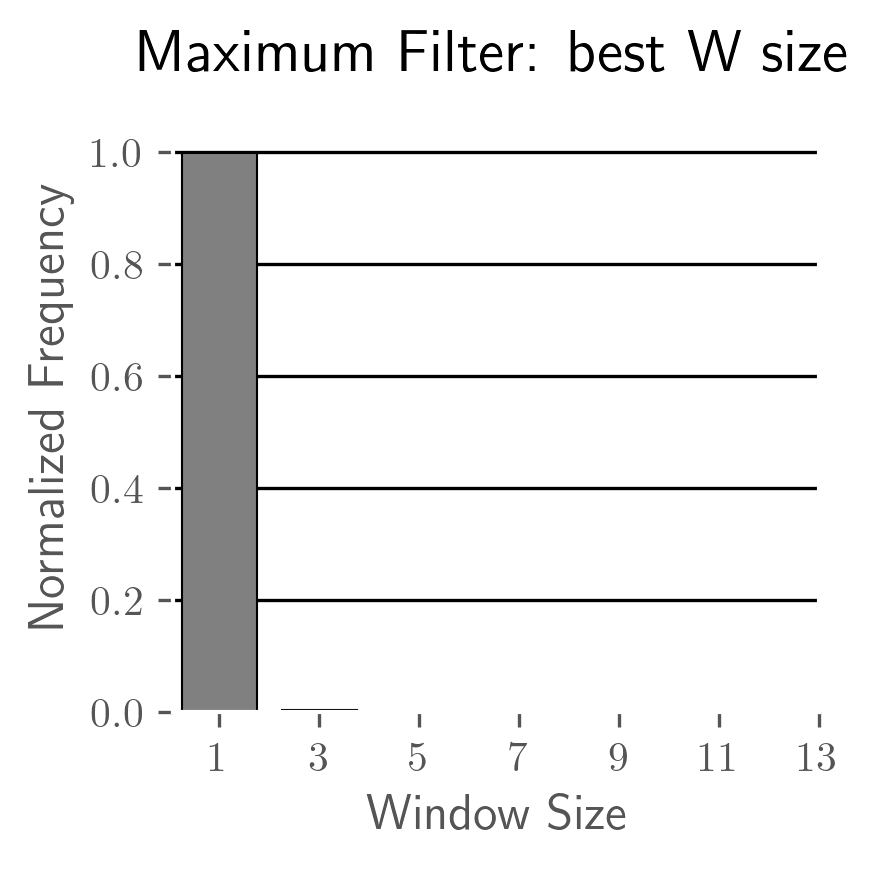

In [9]:
## set the image size
size = 128
## set window sizes
ws = np.arange(1,12,2)
## define a filterFunc lambda function to wrap the skimage function
filterFunc = lambda inputImg, fSize: maximum(inputImg, footprint=np.ones((fSize,fSize)))

### calculate best maximum filter 
best_size_maximum = np.zeros(df_training_set.shape[1])
for i in tqdm.notebook.tqdm(range(df_training_set.shape[1])):
    ## pick the images from the set
    img_input, img_target = dfId2Pics(df_training_set,i, sizes=(128,128))
    ## we need uint8 pictures
    img_input, img_target = (img_input*255.0).astype(np.uint8), (img_target*255.0).astype(np.uint8)
    
    best_size_on_image = np.zeros(ws.shape[0])
    ## loop on the window sizes
    for wid,j in enumerate(ws):
        best_size_on_image[wid]=HuberLoss(img_target/255.0, filterFunc(img_input, j)/255.0, reduction="mean")
    best_size_maximum[i] = ws[np.argmin(best_size_on_image)]

### good window size
proper_window_size = np.argmax(np.bincount(best_size_maximum.astype(int))) 

loss = 0
### loop over all pictures and filter with this window size, to get a correct estimate of the loss
for i in tqdm.notebook.tqdm(range(df_training_set.shape[1])):
    ## pick the images from the set
    img_input, img_target = dfId2Pics(df_training_set,i, sizes=(128,128))
    ## we need uint8 pictures
    img_input, img_target = (img_input*255.0).astype(np.uint8), (img_target*255.0).astype(np.uint8)
    
    loss += HuberLoss(img_target/255.0, filterFunc(img_input, proper_window_size)/255.0, reduction="mean")

### normalize loss
loss /= i

### group values together
best_size_maximum_cut = np.array(sorted([[int(key), float(val)/df_training_set.shape[1]]for key, val in Counter(best_size_maximum).items()], key=lambda x : x[0]))
    
### plot results
plt.figure(figsize=(3,3), dpi=300)
plt.bar(best_size_maximum_cut[:,0], best_size_maximum_cut[:,1], edgecolor="k", facecolor="gray", width=1.5)
plt.xticks(np.arange(1,14,2))
plt.title("Maximum Filter: best W size")
plt.ylim(0,1.1);
print(f"Most common 'good' window size for Maximum filter is {proper_window_size}, with a loss of {loss}")
plt.grid(c="black", axis="y");
plt.xlabel("Window Size"); plt.ylabel("Normalized Frequency")
plt.tight_layout()
### Figure 10, third from left
plt.savefig("./graphs/002_maximum_filter_graph.png")

## 1.4 Minimum Filter

We proceed with the same function. We include the code here again for completeness. The only thing we modify is the `filterFunc` function, which now wraps the minimum filter.

  0%|          | 0/3645 [00:00<?, ?it/s]

  0%|          | 0/3645 [00:00<?, ?it/s]

Most common 'good' window size for Minimum filter is 1, with a loss of 0.00044416519376317066


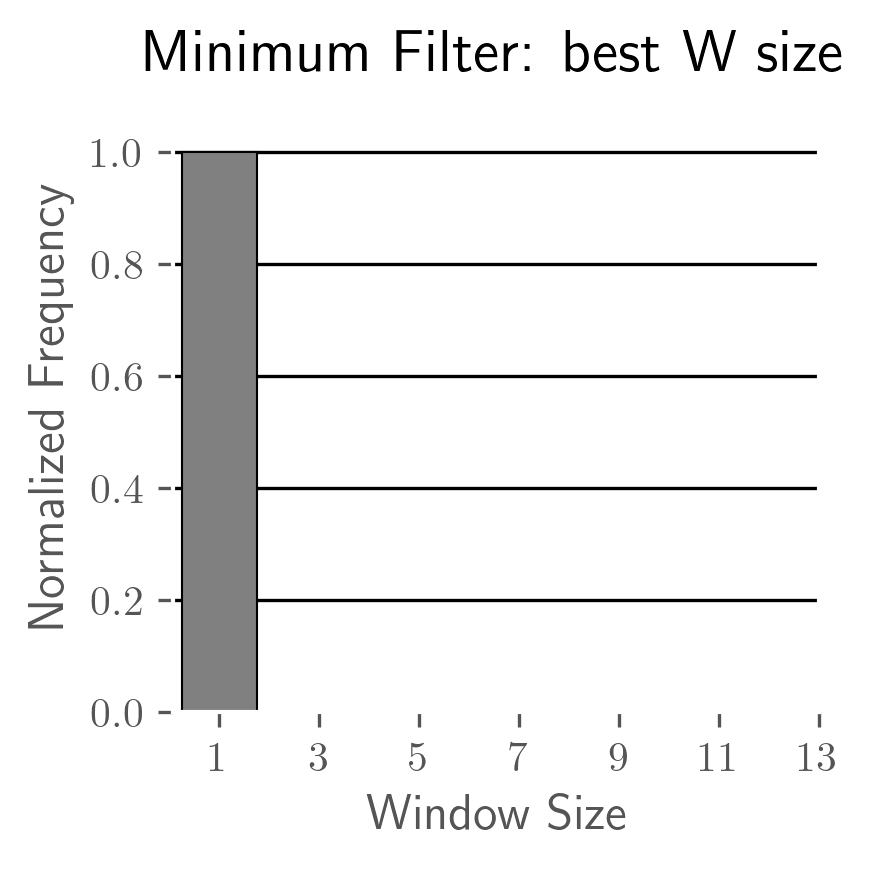

In [10]:
## loop on the entire data set
size = 128
## set window sizes
ws = np.arange(1,12,2)
## define a filterFunc lambda function to wrap the skimage function
filterFunc = lambda inputImg, fSize: minimum(inputImg, footprint=np.ones((fSize,fSize)))

### calculate best minimum filter 
best_size_minimum = np.zeros(df_training_set.shape[1])
for i in tqdm.notebook.tqdm(range(df_training_set.shape[1])):
    ## pick the images from the set
    img_input, img_target = dfId2Pics(df_training_set,i, sizes=(128,128))
    ## we need uint8 pictures
    img_input, img_target = (img_input*255.0).astype(np.uint8), (img_target*255.0).astype(np.uint8)
    
    best_size_on_image = np.zeros(ws.shape[0])
    ## loop on the window sizes
    for wid,j in enumerate(ws):
        best_size_on_image[wid]=HuberLoss(img_target/255.0, filterFunc(img_input, j)/255.0, reduction="mean")
    best_size_minimum[i] = ws[np.argmin(best_size_on_image)]

### good window size
proper_window_size = np.argmax(np.bincount(best_size_minimum.astype(int))) 

loss = 0
### loop over all pictures and filter with this window size, to get a correct estimate of the loss
for i in tqdm.notebook.tqdm(range(df_training_set.shape[1])):
    ## pick the images from the set
    img_input, img_target = dfId2Pics(df_training_set,i, sizes=(128,128))
    ## we need uint8 pictures
    img_input, img_target = (img_input*255.0).astype(np.uint8), (img_target*255.0).astype(np.uint8)
    
    loss += HuberLoss(img_target/255.0, filterFunc(img_input, proper_window_size)/255.0, reduction="mean")

### normalize loss
loss /= i

### group values together
best_size_minimum_cut = np.array(sorted([[int(key), float(val)/df_training_set.shape[1]]for key, val in Counter(best_size_minimum).items()], key=lambda x : x[0]))

### plot results
plt.figure(figsize=(3,3), dpi=300)
plt.bar(best_size_minimum_cut[:,0], best_size_minimum_cut[:,1], edgecolor="k", facecolor="gray", width=1.5)
plt.xticks(np.arange(1,14,2))
plt.title("Minimum Filter: best W size")
plt.ylim(0,1.1);
print(f"Most common 'good' window size for Minimum filter is {proper_window_size}, with a loss of {loss}")
plt.grid(c="black", axis="y");
plt.xlabel("Window Size"); plt.ylabel("Normalized Frequency")
plt.tight_layout()
### Figure 10, fourth from left
plt.savefig("./graphs/003_minimum_filter_graph.png")

## 1.5 Spatial Noise Filters: Conclusion

We have used 4 of the most common spatial noise filtering techniques. Both maximum and minimum filtering achieved the best results for a filter window size of 1, which means that the non-retouched picture is closer to the target than the retouched ones (that is, the filter only worsens the image instead of improving it). This is understandable: as we know, maximum filtering works well on pepper noise, whereas minimum filtering works well on salt noise. Since for both these filters the window size is equal to 1, we can assume that no relevant amount of salt and pepper noise is present in the training set (otherwise larger window sizes would appear in the histograms). As a result, maximum and minimum value filters will not inspected further.

As for the mean and median filters, the Huber losses on the training set are, respectively, 0.00030 and 0.00028. With this finding, we can say that, on the current data set, the median filter performs better than the mean filter. However, we admit that such a small difference may be due to chance and should be treated with caution. Out of the 4 analyzed spatial noise filters, we will take only the median filter to the next stage.

# 2. Non-local Means denoising

For this method, a more complete explanation of its inner working is provided in the report. In summary, Non-Local Means (NLM) splits the image into overlapping patches, then finds the similarity of such patches via a kernel function, computes a similarity-weighted average of the patches, and then uses this as an estimate of the true value for the noisy patch.

NLM is not a particularly difficult algorithm: its implementation only requires less than $20$ lines of code. However, given the large size of required computations and the necessity to finish the calculation in the shortest possible time, we will rely on the highly optimized NLM version included in the `openCV` package. This however requires the setting of several different parameters: <br>
`1.` an input image<br>
`2.` the dimension of the output image (this can be set to `None` if we want input and output images to have the same shape.<br>
`3.` the strength of the filter<br>
`4.` the patch size <br>
`5.` the search window size.

The original paper provides a few rules of thumb to decide the parameters. However, we want to make sure we pick the best parameter set. This is a very slow process. It took about 54 minutes on a MacBook Pro M1 Max on 10 cores. Please note we have manually coded the multi-core computation to save some time. This is done via the definition of `threadNLM` which allows to define a function on the single core, thus allowing some time saving.

In [11]:
def threadNLM(i, X):
    """
    Define the function operated by the single thread during parallel processing. 
    We will use as many threads as the CPU cores in our machine
    Inputs:
    - i : the index of the picture in the df_training_set
    - X : the parameters for optimization
    """
    ## pick the images from the set
    img_input, img_target = dfId2Pics(df_training_set,i, sizes=(128,128))
    ## we need uint8 pictures
    img_input, img_target = (img_input*255.0).astype(np.uint8), (img_target*255.0).astype(np.uint8)
    ### apply denoising
    img_input_denoised = cv2.fastNlMeansDenoising(img_input, None, X[0], int(X[1]), int(X[2]))
    return HuberLoss(img_target/255.0, img_input_denoised/255.0)
    
### the bounds for the variables are therefore included below.
# varbound = [[1.0,99.0],[3,11], [21,35]]
#               h     patch  search window

### generate the parameters' grid for the search
param_grid = [[x,y,z, 0] for x in np.linspace(0,100, 26)[1:] for y in [3,5,7,11] for z in [21,35]]
param_grid = np.array(param_grid)

for row in tqdm.notebook.tqdm(param_grid):
    row[-1] = np.array(Parallel(n_jobs=os.cpu_count())(delayed(threadNLM)(i, row[:-1]) for i in range(df_training_set.shape[1]))).mean()

  0%|          | 0/200 [00:00<?, ?it/s]

In [12]:
best_result = param_grid[param_grid[:,-1].argmin(),:]
print(f"""The best results for non-local means denoising is obtained for:
h={round(best_result[0],5)}
patch= {int(best_result[1])} x {int(best_result[1])}
searchWindowSize = {int(best_result[2])} x {int(best_result[2])}""")

The best results for non-local means denoising is obtained for:
h=12.0
patch= 3 x 3
searchWindowSize = 21 x 21


At this stage, we would like to calculate the loss on the training set for the NLM with the best parameters. 

In [13]:
losses = np.array(Parallel(n_jobs=os.cpu_count())(delayed(threadNLM)(i,best_result) for i in tqdm.notebook.tqdm(range(df_training_set.shape[1]))))
print(f"Achieved Huber Loss is : {np.mean(losses)}")

  0%|          | 0/3645 [00:00<?, ?it/s]

Achieved Huber Loss is : 0.00021802800142215736


Interestingly enough, the non-local means technique achieves, on the training set, a total loss which is about 30% smaller than the median value filtering algorithm and 36% smaller than the mean value filtering. This model seems to have very good potential.

# 3. Denoising via dimensionality reduction techniques

## 3.1 Principal Component Analysis (PCA)

We will here include the code for PCA. We will manually implement PCA via Singular Value Decomposition (SVD). In this implementation, we perform PCA at the image level, instead of the data set level. This allows to perform single-image denoising. In particular, for each picture, we will loop over the amount of retained PCA components, calculate the percentage of retained variance, and choose the amount of retained variance that guarantees the lowest Huber Loss on each image when compared with the reference image. Finally, we will obtain a distribution of percentages of retained variances (one for each picture) and choose the value which minimizes the Huber Loss over the whole data set.

The good point of PCA is that the algorithm can be easily parallelized, and we only need to run the SVD once per each image.


In [14]:
def threadPcaImageMinHuber(i):
    """
    Calculates the amount of variance that needs to be retained in PCA order to 
    achieve the minimum huber loss over the image.
    Inputs:
    i         : the index of the location of the image in the training set
    Outputs:
    out       : amount of retained variance minimizing the average Huber Loss
    """
    
    ### 0. Generate img_input and img_ref from the training set
    ## pick the images from the set
    img_input, img_ref = dfId2Pics(df_training_set,i, sizes=(128,128))
    
    ### 1. center and scale the columns of the image
    means, stds = img_input.mean(axis=0).reshape(1,-1), img_input.std(axis=0).reshape(1,-1)
    ### 1.1 make sure to avoid zero-division
    stds[stds==0] = 1.0
    ### 1.2 normalize image
    img_normalized = (img_input - means)/stds
    
    ### 2. calculate the SVD of the normalized image. Matrices are already sorted by singular values
    u, d, vh = np.linalg.svd(img_normalized)
    
    ### 3. instantiate a vector for the losses
    losses = np.zeros(min(img_input.shape))
    
    ### 4. loop over the reconstructions
    for i in range(len(d)):
        ### 4.1 reconstruct the image
        img_reconstructed = (u[:,:i] @ np.diag(d[:i]) @ vh[:i,:])*stds + means
        ### 4.2 calculate the huber loss
        losses[i] = HuberLoss(img_reconstructed, img_ref)
    
    ### 5. get he index of the minimum loss
    minLoss = np.argmin(losses)
    
    ### 6. get the variance represented by these components
    out = np.sum(d[:minLoss]**2.0)/np.sum(d**2.0)
    
    return out

Now that we have the function that needs to be executed by each thread, we can run PCA in parallel for all the pictures in the training set and obtain the distribution of variances.

In [15]:
### instantiate a vector for the variances
bestVariances = np.array(Parallel(n_jobs=os.cpu_count())(delayed(threadPcaImageMinHuber)(i) for i in tqdm.notebook.tqdm(range(df_training_set.shape[1]))))

  0%|          | 0/3645 [00:00<?, ?it/s]

Now that we have a distribution for the best variances to be retained for each picture, we can plot their distribution.

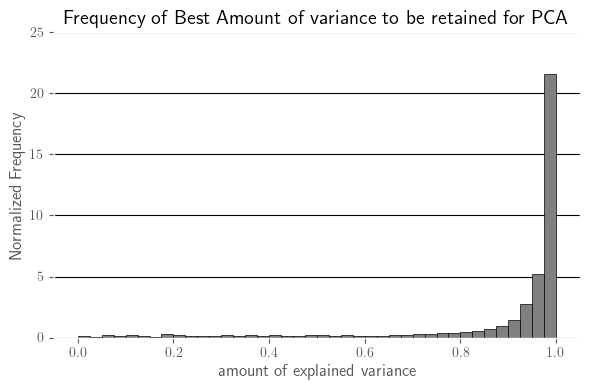

In [16]:
### plot results
plt.figure(figsize=(6,4))
plt.hist(bestVariances, bins=np.linspace(0,1,41), density=True, edgecolor="k", facecolor="gray");
plt.title("Frequency of Best Amount of variance to be retained for PCA")
plt.ylim(0,25.0);
plt.grid(c="black", axis="y");
plt.xlabel("amount of explained variance"); plt.ylabel("Normalized Frequency")
plt.tight_layout()
### Figure 11, first from left
plt.savefig("./graphs/004_pca_filter_graph.pdf")

The graph shows a lower Huber Loss is achieved, in the vast majority of cases, for values of explained variance > 90%. However, the distribution is severely skewed. In this case, the median would be a better estimator for the optimal variance to retain ont he training set.

In [17]:
variance_to_preserve = np.median(bestVariances)
print(f"Variance to discard in order to denoise the picture: {1-variance_to_preserve}")

Variance to discard in order to denoise the picture: 0.020719755408052376


In [18]:
def reconstructImage(img_input, varianceToRetain):
    """
    This function generates the low-rank representation of the input image 
    given a certain amount of variance to retain.
    Inputs:
    - img_input : an np.ndarray representing the image (floating point)
    - varianceToRetain : float. A value specifying the amount of variance to retain in the picture
    Outputs:
    - out : the low-rank representation of the image
    """
    
    ### 1. normalize
    means, stds = img_input.mean(axis=0).reshape(1,-1), img_input.std(axis=0).reshape(1,-1)
    stds[stds==0] = 1.0 # fix 0 variance columns
    img_normalized = (img_input-means)/stds
    
    ### 2. calculate the svd
    u, d, vh = np.linalg.svd(img_normalized)
    
    ### 3. calculate the number of components to guarantee a given amount of variance
    n_comps = np.argmax((np.cumsum(d**2.0)/np.sum(d**2.0))>=varianceToRetain)
    
    ### 4. obtain low-rank representation
    out = (u[:,:n_comps] @ np.diag(d[:n_comps]) @ vh[:n_comps,:])*stds + means
    
    return out

Now, given the variance to retain, we filter all the images accordingly, for each calculate the Huber Loss and then average across the entire training set.

In [19]:
huberPCA = 0

for i in tqdm.notebook.tqdm(range(df_training_set.shape[1])):
    ### 1. Get the image from the training set
    img_input = df_training_set.iloc[:,i].values[1:][:size**2].reshape(size,size)/255.0
    img_ref   = df_training_set.iloc[:,i].values[1:][size**2:].reshape(size,size)/255.0
    ### 2. Obtain Low-rank approximation
    img_reconstr = reconstructImage(img_input, variance_to_preserve)
    ### 3. calculate the Huber Loss
    huberPCA += HuberLoss(img_reconstr, img_ref)

huberPCA /= (i+1)

print(f"The average Huber Loss for PCA-filtered images preserving {variance_to_preserve} is {huberPCA}")

  0%|          | 0/3645 [00:00<?, ?it/s]

The average Huber Loss for PCA-filtered images preserving 0.9792802445919476 is 0.0007893988771582693


## 3.2 Non Negative Matrix Factorization (NMF)

Non-Negative Matrix Factorization (NMF) is the name given to a technique which allows to decompose a matrix $\boldsymbol{V}$ into the product of two matrices $\boldsymbol{W}$ and $\boldsymbol{H}$. This can be applied to matrices of any shapes and sizes, and can be easily calculated via the Lee and Seung multiplicative update rule. 

The benefit of NMF is that encourages the factorization to learn high-level features which are sometimes more interpretable. The implementation of the NMF algorithm is included below.

In [20]:
def NMF(V, subs):
    """
    Given an input image and the number of subcomponents to use, 
    it calculates the non-negative matrix factorization via the Lee and Seung update rule
    Inputs:
    - V : an np.ndarray, in float format, for the input image
    - subs : the number of components to use for the reconstruction
    Outputs:
    - out : the reconstructed Image
    """
    
    ### 1. Instantiate the factorization matrices
    W_old = np.random.uniform(size=(V.shape[0],subs))
    H_old = np.random.uniform(size=(subs, V.shape[1]))
    W_new = np.zeros_like(W_old)
    H_new = np.zeros_like(H_old)
    
    ### 2. Define the reconstruction tolerance and the initial thresholds
    tol = 1/255 # it's useless to refine above the 1/255 pixel value, since images are uint8
    thresh_h = 1
    thresh_w = 1
    
    ### 3. Apply the Lee and Seung Update rule (stop when threshold is hit)
    while not ((thresh_h < tol) & (thresh_w<tol)):
        H_new = H_old * (W_old.T @ V)/(W_old.T@W_old@H_old)
        W_new = W_old * (V@H_new.T)/(W_old@H_new@H_new.T)
        ### calculate the thresholds
        thresh_h = np.abs((H_new-H_old)).max()
        thresh_w = np.abs((W_new-W_old)).max() 
        H_old = H_new
        W_old = W_new
        
    ### 4. Reconstruct the image and output it
    out = W_new@H_new
    
    return out


def getHuberNMF(input_img, ref_img, subs):
    """
    Calculates the huber loss between the NMF-input image and the reference image, for a given rank:
    Inputs:
    - input_img : np.ndarray, the input image to be factorized
    - ref_img   : np.ndarray, the reference image to be factorized
    - subs      : the rank
    Outputs:
    - out       : the huber loss between the reconstructed image and the reference image
    """
    ### 1. calculate the reconstructed image
    reconstructed_img = NMF(input_img, subs)
    
    ### 2. calculate the huber loss
    out = HuberLoss(reconstructed_img, ref_img)
    
    return out

NMF tends to be a very expensive algorithm, given its iterative nature. Increasing the rank of $\boldsymbol{H}$ and $\boldsymbol{W}$ tends to become problematic. In this case, we will only  attempt the reconstruction for the following ranking values $\{ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120\}$

In [21]:
ranks = np.arange(10,128,10)
huberLossNMF = np.zeros((df_training_set.shape[1], len(ranks)))
for i in tqdm.notebook.tqdm(range(df_training_set.shape[1])):
    huberLossNMF[i,:] = np.array(Parallel(n_jobs=os.cpu_count())(delayed(getHuberNMF)(df_training_set.iloc[:,i].values[1:][:size**2].reshape(size,size)/255.0,
                                                                                      df_training_set.iloc[:,i].values[1:][size**2:].reshape(size,size)/255.0,
                                                                                      rank) for rank in ranks))

  0%|          | 0/3645 [00:00<?, ?it/s]

In [22]:
print(f"Minimum Huber Loss Obtained for Rank: {ranks[huberLossNMF.mean(axis=0).argmin()]}")
print(f"Minimum Huber loss {huberLossNMF.mean(axis=0).min()}")

Minimum Huber Loss Obtained for Rank: 50
Minimum Huber loss 0.0003404087046125074


And then plot the results

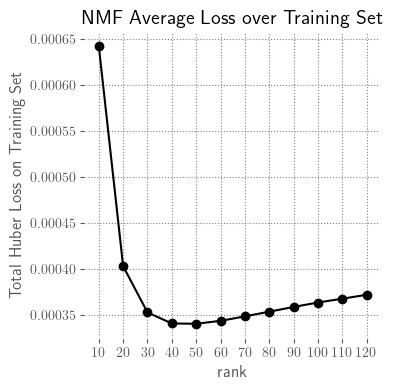

In [23]:
plt.figure(figsize=(4,4))
plt.plot(ranks,huberLossNMF.mean(axis=0), c="k", marker="o")
plt.grid(c="gray", axis="both", ls="dotted")
plt.xticks(ranks);
plt.xlabel("rank")
plt.ylabel("Total Huber Loss on Training Set")
plt.title("NMF Average Loss over Training Set");
plt.tight_layout()
### Figure 11, second from left
plt.savefig("./graphs/005_NMF_filter_graph.pdf")

A rank of 50 seems to guarantee a low loss for most images.

## 3.3 Conclusions

The comparison of NMF and PCA shows that NMF is able to achieve a loss 0.0003 against the 0.0008 value for PCA. As the PCA training loss is almost 3 times worse than the NMF's, we will exclude PCA from further inspection, and only take NMF to the final testing group.

# 4. Deep Learning-based denoising: U-Net

Here we build a fully convolutional neural network for image denoising. In this particular instance, we will use the Huber Loss and the AdamW optimizer - which has been shown to generalize better than vanilla Adam - with a learning rate of $0.001$. Please note that training the network is extremely time consuming. 
Only for the network training, we relied on an nVidia A100, which is able to compute the loss over 1 epoch in just 6 seconds. Older GPUs may be very slow, and computing 3000 epochs as we have done here may require quite some time. We are also including the weights of the network in the file named `model_03000_huberloss.pt`, which we automatically import if available.

## 4.1 Custom `DataSet` class

First of all, the data set that is available to us is not in a common format recognized by PyTorch (for example, categorized images). As a result, we will write the loader by ourselves.

In [24]:
class NoiseDatasetCNN(Dataset):
    def __init__(self, dataFrame, inputTransform=None, targetTransform=None):
        ### set up the data 
        self.dataFrame = dataFrame
        self.inputTransform = inputTransform
        self.targetTransform = targetTransform
        self.size = int(np.sqrt((self.dataFrame.shape[0]-1)/2.0))
        
    def __len__(self):
        ### size method
        return self.dataFrame.shape[1]
    
    def __getitem__(self,idx):
        ### data processing method
        img = self.dataFrame.iloc[:,idx].values[1:]
        ### get input and target images from the dataframe
        inputImg  = img[:self.size**2].reshape(self.size,self.size)
        targetImg = img[self.size**2:].reshape(self.size,self.size)
        inputImg , targetImg = Image.fromarray(inputImg), Image.fromarray(targetImg)
        ### apply appropriate transformations (if there are any)
        if self.inputTransform:
            inputImg = self.inputTransform(inputImg)
        if self.targetTransform:
            targetImg = self.inputTransform(targetImg)
        ### return input and output images
        return inputImg, targetImg
        

We then need to define the transforms to be applied to the images of the `DataSet` class.

In [25]:
transform_for_train = transforms.Compose([transforms.ToTensor()])
transform_for_test = transforms.Compose([transforms.ToTensor()])

We create the training set via the newly created `NoiseDatasetCNN` class.

In [26]:
training_set = NoiseDatasetCNN(df_training_set, inputTransform=transform_for_train, targetTransform=transform_for_train)

## 4.2 Building the `DataLoader`s

We then define the data loaders to load in the data seamlessly, in batches of 128 images, and shuffle between one epoch and the other.

In [27]:
training_loader = torch.utils.data.DataLoader(dataset = training_set , batch_size = 128 , shuffle = True)

We will now show a few images from the `Dataloader`.

In [28]:
ins, outs = next(iter(training_loader))
ins , outs = ins.squeeze(), outs.squeeze()

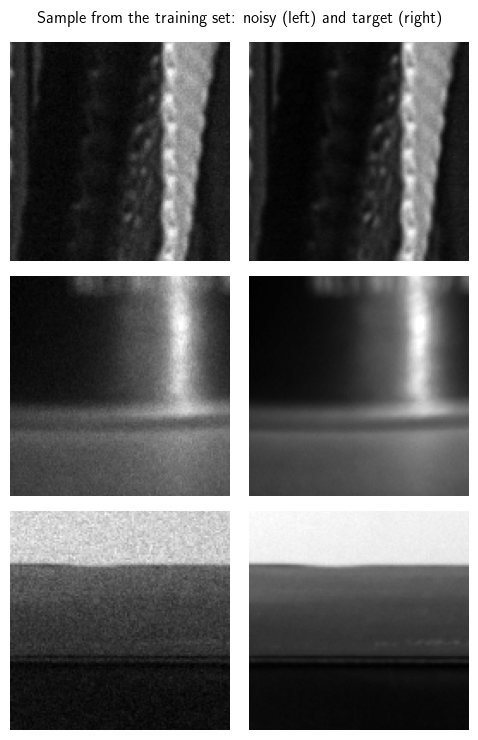

In [29]:
plotN = 3
width = 5

fig, ax = plt.subplots(nrows=plotN, ncols=2, figsize=(width,width/2*plotN))
for i in range(plotN):
    ### plot all the pictures. On the left the inputs and on the right the outputs.
    ax[i,0].imshow(ins[i], cmap="gray")
    ax[i,0].axis("off")
    ax[i,1].imshow(outs[i], cmap="gray")
    ax[i,1].axis("off")

plt.suptitle("Sample from the training set: noisy (left) and target (right)")
plt.tight_layout()

## 4.3 Building U-Net


For this particular problem, we will use a U-Net architecture. U-nets are very popular in image-to-image translation problems, such as MRI segmentation, image denoising and so on. In U-nets, we need a section where the network "shrinks" the image, distillating all the important features and removing the noise, and another section where the images are upsampled and the result is - ideally - noiseless.
In order to achieve greater modularity, we will implement the contracting and the upsampling sections separately.

### 4.3.1 Contraction

In [30]:
def Contraction(in_channels : int, out_channels : int , activation=nn.ReLU(inplace=True), poolBefore = False):
    """
    This function generates a contraction block for U-Net
    Inputs:
    - in_channels : the number of input channels
    - out_channels : the number of output channels
    - activation : an activation function
    - poolBefore : a flag which lets the user decide whether max pooling should be applied before the layer or not.
    Outputs:
    - network : the contraction block as `nn.Sequential`
    """
    network = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
                             nn.BatchNorm2d(out_channels),
                             activation,
                             nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
                             nn.BatchNorm2d(out_channels),
                             activation)
    
    ### add a max pooling layer before the convolution if needed (optional)
    if poolBefore:
        network = nn.Sequential(nn.MaxPool2d(2), network)
                             
    return network

### 4.3.2 Upsampling

We will here create a class for upsampling, as this process is slightly more complex than the contraction part.

In [31]:
class upSampling(nn.Module):
    """
    This class generates an upsampling block for U-Net
    Inputs:
    - in_channels : the number of input channels
    - out_channels : the number of output channels
    - activation : the activation function
    """
    def __init__(self, in_channels, out_channels, activation=nn.ReLU(inplace=True)):
        super(upSampling, self).__init__()
        self.upSample = nn.ConvTranspose2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=2, stride=2)
        self.convolution = Contraction(in_channels, out_channels, activation=activation)
        
    def forward(self, x, y):
        """
        Pushes the image x through the network and concatenates y
        """
        x = self.upSample(x)
        dX = y.shape[3] - x.shape[3]
        dY = y.shape[2] - x.shape[2]
        ### padding x with the appropriate size tensor
        x = F.pad(x,[dX//2,dX-dX//2,dY//2,dY-dY//2])
        x = torch.cat([x,y], dim=1)
        ### apply convolution and return value
        return self.convolution(x)

### 4.3.3 Putting everything together

Here we will put the U-Net together by assembling contractions and upsampling.

In [32]:
class unet(nn.Module):
    """
    The class representing U-net, with 5 downsampling and 5 upsampling blocks. The bottleneck features 1024 layers.
    The value of input_channels depends on the picture at hand. In case of grayscale images, this should be equal to 1
    """
    def __init__(self, input_channels, activation=nn.ReLU(inplace=True)):
        super(unet,self).__init__()
        
        self.input_channels = input_channels
        
        self.downSample1 =   Contraction(self.input_channels,   64, activation=activation, poolBefore = False)
        self.downSample2 =   Contraction(                 64,  128, activation=activation, poolBefore = True )
        self.downSample3 =   Contraction(                128,  256, activation=activation, poolBefore = True )
        self.downSample4 =   Contraction(                256,  512, activation=activation, poolBefore = True )
        self.downSample5 =   Contraction(                512, 1024, activation=activation, poolBefore = True )
        
        self.upSample1   = upSampling(1024,                  512, activation=activation)
        self.upSample2   = upSampling( 512,                  256, activation=activation)
        self.upSample3   = upSampling( 256,                  128, activation=activation)
        self.upSample4   = upSampling( 128,                   64, activation=activation)
        self.upSample5   = nn.Conv2d(  64,  self.input_channels, kernel_size=1)
        
    def forward(self, x):
        
        ### Downsampling Section
        out1 = self.downSample1(   x)
        out2 = self.downSample2(out1)
        out3 = self.downSample3(out2)
        out4 = self.downSample4(out3)
        out5 = self.downSample5(out4)
        
        ### Upsampling Section
        out = self.upSample1(out5, out4)
        out = self.upSample2(out, out3)
        out = self.upSample3(out, out2)
        out = self.upSample4(out, out1)
        out = self.upSample5(out)        
        return out

We now choose the device to run the model on. We use Apple GPU via `mps` if this is available. Otherwise, `cuda` if the machine supports it. If none of the previous two options are available, we will switch to `cpu` training. 

In [33]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(f"The calculations will be performed on {device}")

The calculations will be performed on mps


We then instantiate a U-net and send it to the appropriate device.

In [34]:
model = unet(input_channels=1, activation=nn.GELU())

summary(model, input_size=(1,1,128,128), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
unet                                     [1, 1, 128, 128]          --
├─Sequential: 1-1                        [1, 64, 128, 128]         36,992
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         576
│    └─BatchNorm2d: 2-2                  [1, 64, 128, 128]         128
├─upSampling: 1-32                       --                        (recursive)
│    └─Sequential: 2-41                  --                        (recursive)
│    │    └─GELU: 3-1                    [1, 64, 128, 128]         --
├─Sequential: 1-3                        --                        (recursive)
│    └─Conv2d: 2-4                       [1, 64, 128, 128]         36,864
│    └─BatchNorm2d: 2-5                  [1, 64, 128, 128]         128
├─upSampling: 1-32                       --                        (recursive)
│    └─Sequential: 2-41                  --                        (recursive)
│    │    └─GELU: 3-2        

In [35]:
model.to(device);

We have about 31 million parameters in total. We will train out network with the Huber Loss for 3000 epochs.

In [36]:
### This cell is quite time consuming. We set the seed 
### here again to obtain reproducibility without running 
### the cells above again
np.random.seed(CID)
torch.manual_seed(CID)

### If the model weights are available, load the model, otherwise, train it
### The weights can be found at https://imperiallondon-my.sharepoint.com/:u:/g/personal/fn321_ic_ac_uk/EQNZwrKsj-hCrced0XMius4BAPI4SIuimGOBLjsxdoZRRA?download=1
if os.path.exists("model_03000_huberloss.pt"):
    model = torch.load("model_03000_huberloss.pt")
    model.to(device)
else:
    ### set number of epochs
    num_epochs = 3000
    loss_history = []

    for criterion in [nn.HuberLoss(delta=0.2)]: ### we use HuberLoss. 
        print(f"Now Using {str(criterion.type).split()[-1][:-3].upper()}")
        #### 1. Instantiate the model and send to a device
        model = unet(input_channels=1, activation=nn.GELU())
        model.to(device);
        #### 2. Instantiate an optimizer (Adam in this case)
        optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
        #### 3. Train the model
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            for inputs, targets in tqdm.notebook.tqdm(training_loader):
                inputs, targets = inputs.to(device), targets.to(device).squeeze()
                outputs = model(inputs).squeeze()
                loss = criterion(torch.sigmoid(outputs).squeeze(), targets.float())
                ## optimize gradient and update weights
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                ## sum loss to total loss
                total_loss += loss.detach().cpu()*targets.shape[0]

            #### 4. normalize loss
            total_loss /= len(training_set)
            loss_history.append(total_loss)
            print(f"The mean loss at epoch {epoch} is {total_loss}")

    #### 5. save model 
    torch.save(model.state_dict(), f"model_{str(epoch).zfill(5)}_{str(criterion.type).split()[-1][:-3].lower()}.pt")
    
    #### 6. plot the history
    plt.figure(figsize=(8,4))
    plt.plot(loss_history, c="k")
    plt.xlabel("Epoch")
    plt.ylabel("Huber Loss, $\epsilon=0.2$")
    plt.grid()
    plt.title("Training Loss History")
    plt.grid(c="gray", axis="both", linestyle='--');
    plt.ylim(0,0.004)
    ### Figure 12
    plt.savefig("graphs/006_lossHistory.pdf")

This completes the model training phase. A large number of epochs is necessary for the weights to properly stabilize. Training for less than 2500 epochs leads to underwhelming results.

# 5. Evaluation

After the training phase, it is now time to evaluate the models. The evaluation phase will be performed in two steps:

1. We will apply the chosen methods to 90% of the test set and, for each method, calculate the Huber Loss and use an aggregation function (mean in this case). This will provide a quantitative measure of the quality of the de-noising algorithm on the test set. The set used here will be referred to as `machineSet`.
1. Next, we will administer the test to two individuals. The test is structured in the following way:
    1. Pick the remaining 10% of the test set. And for each image:
        1. Calculate the 4 de-noised images corresponding to the application of mean filter, non-local means, NMF and U-net.
        1. Shuffle the order.
        1. Include, in a slide, the ground truth on the left and the three pictures on the right. The interviewed person will have to choose the image that looks most similar to the ground truth.
    1. Aggregate the findings and compare the "human-eye" loss with the numerical one. And check whether the results agree or not. 
This set will be instead be referred to as `humanSet`.
    
Fist of all, recall the optimal models:
1. Median Filter with window of size 3
1. Non-Local Means with strength 12, patch size 3x3 and search window size 21x21
1. NMF with Rank 50
1. The U-Net model (whose weights cannot be easily identified for obvious reasons)

## 5.1 Machine Evaluation

In this section, we will evaluate the previously discussed models on the `machineSet`.

### 5.1.1 Median Filter

As previously discussed, a median filter of size `3x3` seems to perform fairly well on the training set. We will apply this to machine test set, and then calculate the average Huber Loss.

In [37]:
### loop over images on the machine set and perform median value filtering using a 3x3 window
testLoss_median_machine = 0.0
for i in tqdm.notebook.tqdm(range(machineSet.shape[1])):
    img_input, img_target = dfId2Pics(machineSet, i, sizes=(size,size))
    ### apply median filtering to the image
    img_filtered = median((img_input*255.0).astype(np.uint8), footprint=np.ones((3,3)))/255.0
    ### accumulate loss
    testLoss_median_machine += HuberLoss(img_filtered, img_target)

testLoss_median_machine /= (i+1)

print(f"The loss on the machine test set for median filtering is {testLoss_median_machine}")

  0%|          | 0/360 [00:00<?, ?it/s]

The loss on the machine test set for median filtering is 0.0002951253841859202


### 5.1.2 Non-Local Means

In this section, we will apply NLM to the machine test set and calculate the loss. 

In [38]:
### loop over images on the machine set and perform NLM filtering
testLoss_NLM_machine = 0.0

for i in tqdm.notebook.tqdm(range(machineSet.shape[1])):
    img_input, img_target = dfId2Pics(machineSet, i, sizes=(size,size))
    ### apply NLM filtering to the image
    img_filtered = cv2.fastNlMeansDenoising((img_input*255.0).astype(np.uint8), None, int(best_result[0]), int(best_result[1]), int(best_result[2]))/255.0 
    ### accumulate loss
    testLoss_NLM_machine += HuberLoss(img_filtered, img_target)

testLoss_NLM_machine /= (i+1)

print(f"The loss on the machine test set for Non-Local Means filtering is {testLoss_NLM_machine}")

  0%|          | 0/360 [00:00<?, ?it/s]

The loss on the machine test set for Non-Local Means filtering is 0.0002362236177108028


### 5.1.3 Non-Negative Matrix Factorization

In this section, we will use NMF to calculate the loss on the machine set. The training set revealed that a rank of $50$ guarantees the lowest loss on the training set.

In [39]:
testLoss_NMF_machine = 0.0
rank = 50

for i in tqdm.notebook.tqdm(range(machineSet.shape[1])):
    ### loop over the entire machine Set and obtain the 
    img_input, img_target = dfId2Pics(machineSet, i, sizes=(size,size))
    testLoss_NMF_machine += getHuberNMF(img_input, img_target, rank)

testLoss_NMF_machine /= (i+1)
print(f"The loss on the machine test set for Non-negative matrix factorization is {testLoss_NMF_machine}")

  0%|          | 0/360 [00:00<?, ?it/s]

The loss on the machine test set for Non-negative matrix factorization is 0.0003396244035852946


### 5.1.4 U-Net

Finally, we will use the trained `U-Net` for denoising the test set.

In [40]:
machine_set = NoiseDatasetCNN(machineSet, inputTransform=transform_for_test, targetTransform=transform_for_test)
machine_loader  = torch.utils.data.DataLoader(dataset = machine_set  , batch_size = 128 , shuffle = True)

human_set = NoiseDatasetCNN(humanSet, inputTransform=transform_for_test, targetTransform=transform_for_test)
human_loader  = torch.utils.data.DataLoader(dataset = human_set  , batch_size = 128 , shuffle = True)

We then set the model to `eval` state so that we instruct the code not save the gradients during the calculations

Finally, we loop over the machine set loader and obtain the denoised images, accumulate the loss, and finally obtain the average loss across the entire data set.

In [41]:
with torch.no_grad():
    ### 1. set the loss criterion
    criterion = nn.HuberLoss(delta=0.2)
    ### 2. modify network state
    model.eval()
    ### 3. zero the loss
    testLoss_UNET_machine = 0
    ### 4. loop over machine set and sum the loss
    for inputs, targets in tqdm.notebook.tqdm(machine_loader):
        inputs, targets = inputs.to(device), targets.to(device).squeeze()
        outputs = model(inputs).squeeze()
        loss = criterion(torch.sigmoid(outputs).squeeze(), targets.float())
        ### sum the loss over all the images
        testLoss_UNET_machine += loss.detach().cpu()*targets.shape[0]

    #### 5. normalize the loss
    testLoss_UNET_machine /= len(machine_set)

    print(f"The loss on the machine test set for the U-Net is {testLoss_UNET_machine}")

  0%|          | 0/3 [00:00<?, ?it/s]

The loss on the machine test set for the U-Net is 0.00015952378453221172


### 5.1.5 Conclusions on the Machine Evaluation set.

We can now compare the loss for the three models on the `machineSet`

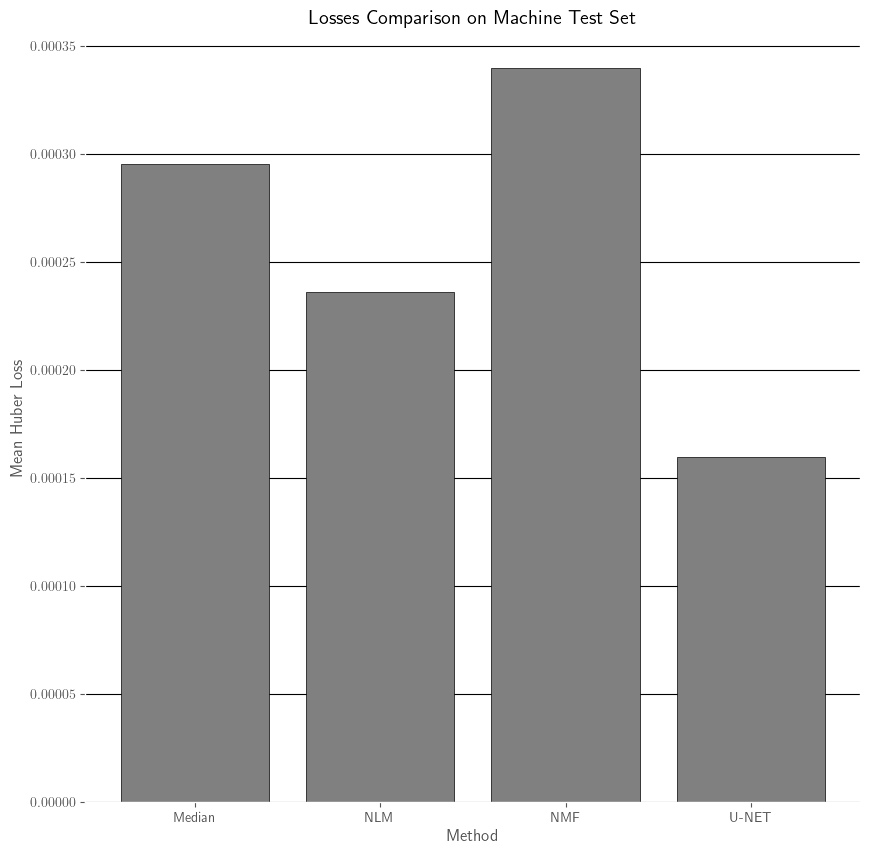

In [42]:
losses = [testLoss_median_machine, testLoss_NLM_machine, testLoss_NMF_machine, testLoss_UNET_machine.item()]
methods = ["Median", "NLM", "NMF", "U-NET"]
numbers = list(range(len(methods)))

### Plot the loss functions
plt.bar(numbers, losses, edgecolor="k", facecolor="gray")
ax = plt.gca()
ax.set_xticks(numbers)
ax.set_xticklabels(methods);
plt.title("Losses Comparison on Machine Test Set")
plt.grid(c="black", axis="y");
plt.xlabel("Method"); plt.ylabel("Mean Huber Loss")
plt.savefig("./graphs/007_machineSet_Loss_graph.pdf")

## 5.2 Human Evaluation

### 5.2.1 Survey preparation

As we previously explained previously, we will also have a human evaluator check the results and choose the best performing model on a given subset of the test set (also called `humanSet`).

We will create a folder, called `survey` where we will include the survey for each individual. 

In [43]:
survey_dir = "survey"
os.makedirs(survey_dir, exist_ok=True)
# ### to check the installed fonts, replace Tahoma.ttf in the code cell below ##############
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
# ##########################################################################################

The survey creation will be defined as below.

- set the seed
- for each human evaluator [1-2]:
  - create an empty file
  - for each image [1-45]:
    - create a new page in the file
    - get the reference image and place it on the top row
    - for each model [Median, NLM, NMF, UNET]:
      - denoise the input image
    - shuffle the images from the models (to force the surveyee to focus on the content rather than on the location)
    - include the images in the bottom row and record the ordering in a separate survey answer file
    
The implementation will be slightly different in the code, for speed of survey creation. First, we define a helper function that will allow us to create a page of the survey, given the reference and the output images. Make sure to modify the font location according to your system. We tested this code on a Mac, but the Font path may be different on Ubuntu/Windows.

In [44]:
def generatePage(imgList : list, topRight_index : str , outputName : str) -> None:
    """
    This function generates a page for the survey. It takes the following arguments:
    Inputs:
    - imgList : a list of 5 items representing the objects to compare. The first item
                needs to be the reference image.
    - topRight_index : a string for the index to be shown on the top right of the figure
    - outputName : the output for the image to be exported
    Outputs:
    - None (the pdf is exported, but the function output is None).
    """

    assert len(imgList)==5, "imgList must have exactly 5 elements"
    
    imgs = imgList
    size = imgs[0].shape
        
    ### 1. pad images
    pads = 10
    for i,img in enumerate(imgs):
        imgs[i] = np.pad(img, ((pads,pads),(pads,pads)), mode="constant", constant_values=1)

    ### 2. assemble images
    sep = 10 # separator between columns
    right_column = np.concatenate(imgs[1:], axis=0)
    left_column = np.ones((right_column.shape[0],right_column.shape[1]+sep))
    page = np.concatenate((left_column, right_column), axis=1)

    ### 3. place reference image
    start_r = left_column.shape[0]//2 - imgs[0].shape[0]//2 
    end_r = start_r + imgs[0].shape[0]
    start_c = 0
    end_c = imgs[0].shape[1]
    page[start_r:end_r, start_c:end_c] = imgs[0]

    ### 4. Add a title to the page
    title = topRight_index
    page = np.concatenate((np.ones((0,page.shape[1])), page), axis=0)

    ### 5. Add Text
    page = Image.fromarray((page*255.0).astype(np.uint8).T)
    draw = ImageDraw.Draw(page)
    font = ImageFont.truetype("/System/Library/Fonts/Supplemental/Tahoma.ttf",18) ## this line needs to be modified depending on the machine
    draw.text((2, 2)," Select the picture in the\n bottom row which most\n resembles the one in the\n top row.",(0),font=font)
    draw.text((page.size[0]-60, 2),title,(0),font=font)

    ### 6. Export to pdf
    page.save(outputName)

The code below instead generates multiple pdfs (one per page)

In [45]:
### set the seed here again in order to obtain the same surveys at each run
np.random.seed(CID)
torch.manual_seed(CID)

### set the humanSet for pytorch loading
humanSet_pytorch = NoiseDatasetCNN(humanSet, inputTransform=transform_for_test, targetTransform=transform_for_test)

### dictionary for mapping code to algorithm and algorithm to code
algo2code = {"median":0, "nlm":1, "nmf":2, "unet":3}
code2algo = {value:key for key,value in algo2code.items()}

### 0. set seed
np.random.seed(CID)
### 1. loop on the human observers:
for human in range(2):
    ### 2. loop over the human set
    ### 2.1 set an "answer" list, that keeps track of the shuffling
    answer = []
    for i in range(humanSet.shape[1]):
        ### 3. get input and target images
        img_input, img_target = dfId2Pics(humanSet, i, sizes=(size,size))
        ### 4. perform [Median, NLM, NMF, UNET] denoising on img_input
        
        #### 4.1 Median
        img_Median = median((img_input*255).astype(np.uint8))/255.0
                       
        #### 4.2 NLM
        img_NLM = cv2.fastNlMeansDenoising((img_input*255).astype(np.uint8), None, int(best_result[0]), int(best_result[1]), int(best_result[2]))/255.0 
        
        #### 4.3 NMF
        img_NMF = NMF(img_input, 50)
        
        #### 4.4 Unet
        with torch.no_grad():
            img_Unet = (torch.sigmoid(model(humanSet_pytorch[i][0].unsqueeze(0).to(device)))).squeeze().detach().cpu()
        
        #### 5. Clip images to fall within range
        image_list = [ np.clip(img, 0.0, 1.0) for img in [img_target, img_Median, img_NLM, img_NMF, img_Unet]]
        
        #### 6. Shuffle the images and keep track of the shuffling
        shuffleIdx = np.random.permutation(4).tolist()
        image_list = [image_list[0]] + [image_list[idx+1] for idx in shuffleIdx]     
        answer.append([code2algo[idx] for idx in shuffleIdx])
        
        #### 6 Include the pictures in a pdf
        generatePage(image_list, topRight_index=f"{i+1}/45", outputName=f"survey/u_{human}_{i+1}.pdf")
    
    answer = pd.DataFrame(np.array(answer))
    ### save the encoded answers
    answer.to_csv(f"survey/answer_{human}.csv", index=None)

We then merge the pdf of each user into a single pdf for each surveyee.

In [46]:
### loop on the number of users and merge
for i in range(2):
    pdf_list = natsorted(glob.glob(f"./survey/u_{i}_*"))
    merger = PdfMerger()

    for pdf in pdf_list:
        merger.append(pdf)

    merger.write(f"survey/survey_u{i}.pdf")
    
    for pdf in pdf_list:
        os.remove(pdf)

This completes the survey preparation.

### 5.2.2 Survey Results

**##########SECTION 5.2.2 WILL NOT RUN UNLESS survey_result folder IS AVAILABLE. MAKE SURE TO SKIP THIS SECTION AND GO DIRECTLY TO SECTION 6 IF THE SURVEY RESULTS ARE TO BE EXCLUDED. ################################** 

We asked two individuals to take visual comparison test. The pictures are all shuffled at each page, and the user has to pick the picture most resembling the one in the top row of the page. The results are all included in the folder `survey_result`. Where:
- `answer_*.csv` includes the method for each of the pictures for surveyee `*`
- `survey_u*.pdf` includes the filled survey by surveyee `*`
- `survey_u*.csv` includes the result from the form filled by surveyee `*`.

In [47]:
### select the surveyee
count = Counter()
for u in range(2):
    u = 1
    answers = pd.read_csv(f"survey_result/survey_u{u}.csv", header=None).values[:,0].astype(int).tolist()
    encoding = pd.read_csv(f"survey_result/answer_{u}.csv").values.tolist()
    result = [ encoding[i][answer-1] for i, answer in enumerate(answers)]
    count += Counter(result)

In [48]:
print(count)

Counter({'unet': 56, 'nlm': 28, 'median': 4, 'nmf': 2})


According to these results, `unet` is the best performer of the 4 models. If we create a graph "similar" to the one for the loss, to compare human perception and numerical results:

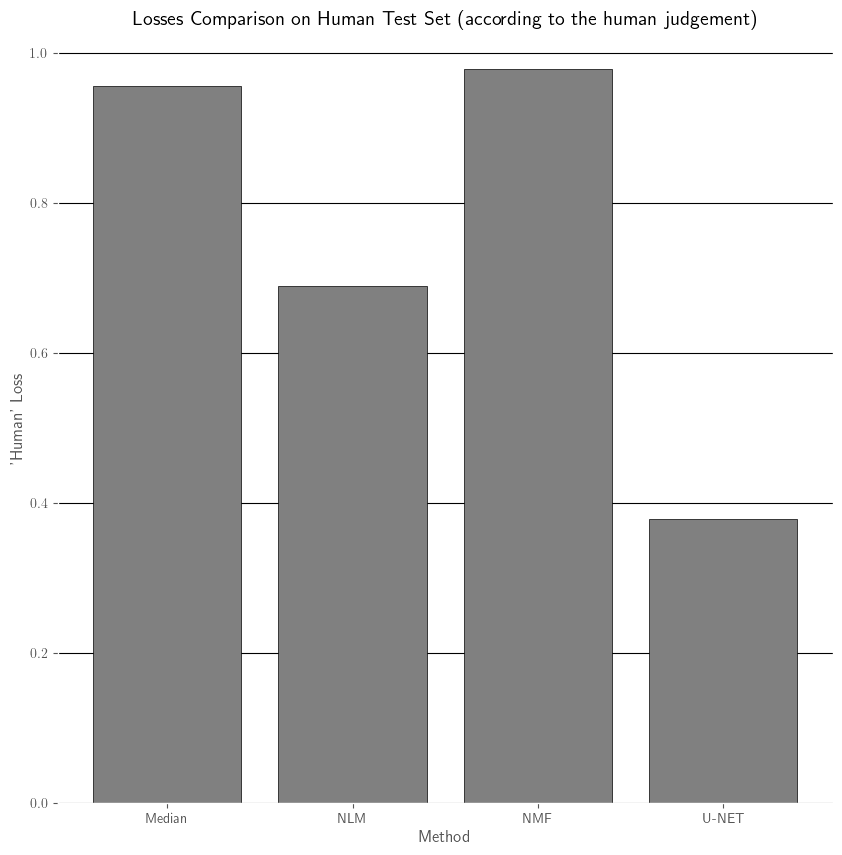

In [49]:
methods = ["Median", "NLM", "NMF", "U-NET"]
### generate the "losses" by creating the graph of the proportion of times a certain method didn't "win" in the competition
tot_imgs = len(human_set)*2
losses = [(tot_imgs-count[method.lower().replace("-","")])/tot_imgs for method in methods]
numbers = list(range(len(methods)))

### Plot the loss functions
plt.bar(numbers, losses, edgecolor="k", facecolor="gray")
ax = plt.gca()
ax.set_xticks(numbers)
ax.set_xticklabels(methods);
plt.title("Losses Comparison on Human Test Set (according to the human judgement)")
plt.grid(c="black", axis="y");
plt.xlabel("Method"); plt.ylabel("'Human' Loss")
plt.savefig("./graphs/009_humanSet_perception_graph.pdf")

We would now like to calculate the mean improvement of U-Net over NMF using the Boostrap approach.

In [50]:
np.random.seed(CID)
### get the probabilities for the counts
probs = np.array([element[1] for element in list(count.most_common())])
### get total number of data points
n = np.sum(probs)
probs = probs/n

### select the total number of iterations
totIts = 100000
diff = np.zeros((totIts))
### draw 10000 times
for i in tqdm.notebook.tqdm(range(totIts)):
    draw =  np.random.choice(4, p=probs,size=n)
    diff[i] = np.sum(draw==0)-np.sum(draw==1)
    
print(f"Bootstrap distribution for U-Net/NLM difference results in mean: {np.mean(diff)} and standard deviation: {np.std(diff,ddof=1)}")
print(f"Probability of U-Net outperforming NLM is : {np.mean(diff>0)}")

  0%|          | 0/100000 [00:00<?, ?it/s]

Bootstrap distribution for U-Net/NLM difference results in mean: 27.98778 and standard deviation: 8.65927482541148
Probability of U-Net outperforming NLM is : 0.99906


# 6. Extra Images for the report

**##########         THIS SECTION WILL NOT RUN IF image_rep.png IS NOT AVAILABLE. MAKE SURE YOU PLACE IT IN THE FOLDER          ##########**

In this section, we will include some extra images that are not needed in the context of the notebook, but only in the context of the report. We first create the appropriate folder.

In [51]:
report_folder = "imgs_report"
os.makedirs(report_folder, exist_ok=True)

and then load the reference image. **Make sure that `image_rep.png` exists or this code will not run**

(-0.5, 127.5, 127.5, -0.5)

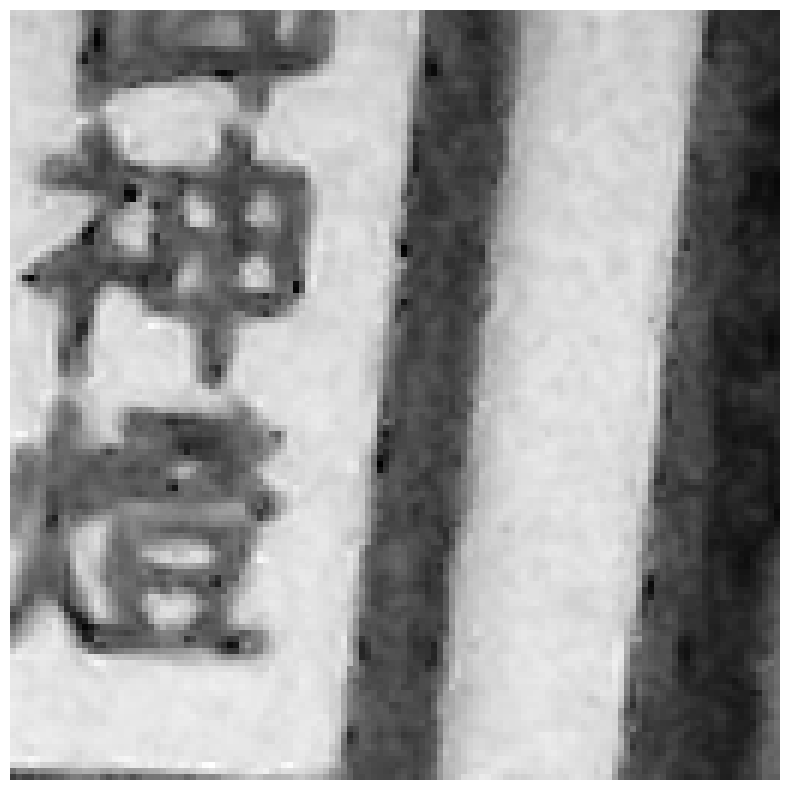

In [52]:
img_ref = cv2.imread("image_rep.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img_ref, cmap="gray")
plt.axis("off")

The following section will process the image using all the algorithms described above.

## 6.1 Mean Value Filtering

In [53]:
proc_mean = mean(img_ref, footprint=np.ones((3,3)))
### Figure 4, second from left
cv2.imwrite(os.path.join(report_folder,"mean_filter.png"),proc_mean)

True

## 6.2 Median Value Filtering

In [54]:
proc_median = median(img_ref, footprint=np.ones((3,3)))
### Figure 4, third from left
cv2.imwrite(os.path.join(report_folder,"median_filter.png"),proc_median)

True

## 6.3 Maximum Value Filtering

In [55]:
proc_maximum = maximum(img_ref, footprint=np.ones((3,3)))
### Figure 4, fourth from left
cv2.imwrite(os.path.join(report_folder,"maximum_filter.png"),proc_maximum)

True

## 6.4 Minimum Value Filtering

In [56]:
proc_minimum = minimum(img_ref, footprint=np.ones((3,3)))
### Figure 4, fifth from left
cv2.imwrite(os.path.join(report_folder,"minimum_filter.png"),proc_minimum)

True

## 6.5 Non-Local Means

In [57]:
### the first image from the left is image_rep.png

### Figure 5, second from left
cv2.imwrite(os.path.join(report_folder, "proc_nlm_7p5_3_21.png"),cv2.fastNlMeansDenoising(img_ref, None, 7.5*0.4, 3, 21))
### Figure 5, third from left
cv2.imwrite(os.path.join(report_folder, "proc_nlm_22p5_5_21.png"),cv2.fastNlMeansDenoising(img_ref, None, 22.5*0.4, 5, 21))
### Figure 5, fourth from left
cv2.imwrite(os.path.join(report_folder, "proc_nlm_60_9_35.png"),cv2.fastNlMeansDenoising(img_ref, None, 60*0.35, 9, 35))
### Figure 5, fifth from left
cv2.imwrite(os.path.join(report_folder, "proc_nlm_87p5_11_35.png"),cv2.fastNlMeansDenoising(img_ref, 87.5*0.35, 11, 35))

True

## 6.4 Principal Component Analysis

In [58]:
### cast to float in 0-1 interval
img_pca = img_ref/255.0
### retain only per_var and save to image
for per_var in [0.5, 0.7, 0.9, 0.99]:
    img_recon = (reconstructImage(img_pca,per_var)*255.0).astype(np.uint8)
    ### Figure 6, second-third-fourth-fifth from left
    cv2.imwrite(os.path.join(report_folder, f"proc_pca_{per_var}.png"), img_recon)

## 6.5 Non-Negative Matrix Factorization

In [59]:
img_nmf = img_ref/255.0
for rank in [5,20,60,128]:
    ### Figure 7, second-third-fourth-fifth from left
    cv2.imwrite(os.path.join(report_folder, f"proc_nmf_{rank}.png"),(NMF(img_nmf,rank)*255.0).astype(np.uint8))

## 6.6 U-Net

Process U-Net Output

In [60]:
with torch.no_grad():
    ### Figure 9, second from left
    cv2.imwrite(os.path.join(report_folder, "proc_unet.png"),
                (torch.sigmoid(model(torch.tensor((img_ref/255.0).astype(np.float32)).unsqueeze(0).unsqueeze(1).to(device))).squeeze().detach().cpu().numpy()*255.0).astype(np.uint8))

## 6.7 DataSet Sample

Plot the Input

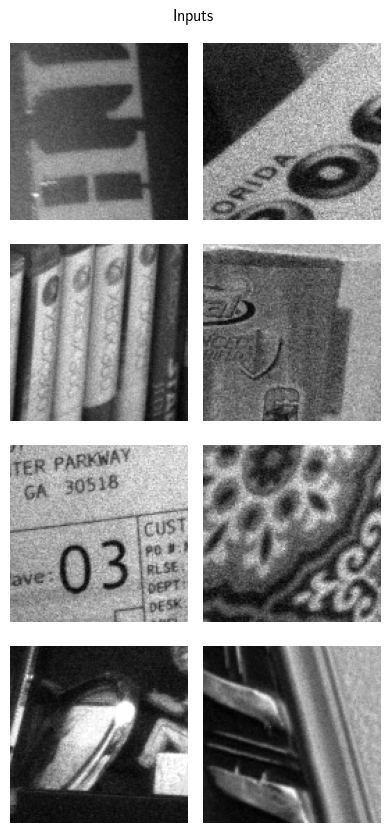

In [61]:
picsToShow = [0,8,2000, 40, 68, 79, 104, 1600]
figure, ax = plt.subplots(nrows=4, ncols=2, figsize=(4,8.5))
for i in range(8):
    outs = dfId2Pics(dataset, picsToShow[i])
    x_val , y_val = np.unravel_index(i,(4,2))
    ax[x_val,y_val].imshow(outs[0], cmap="gray")
    ax[x_val,y_val].grid(False)
    ax[x_val,y_val].axis("off")
plt.suptitle("Inputs")
plt.tight_layout()
plt.savefig(os.path.join(report_folder, "inputs_dataset.png"))

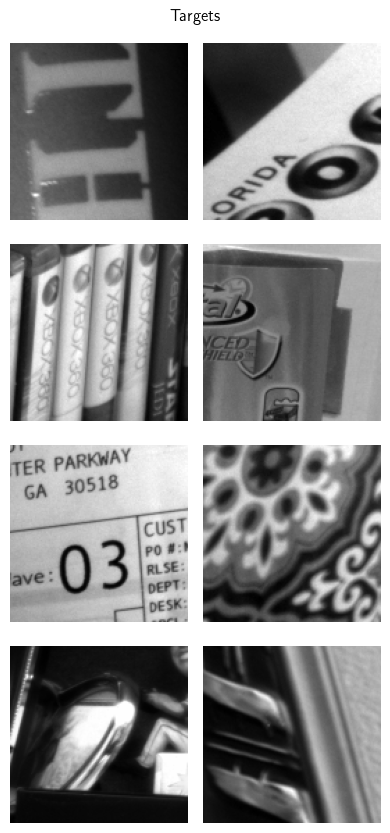

In [62]:
picsToShow = [0,8,2000, 40, 68, 79, 104, 1600]
figure, ax = plt.subplots(nrows=4, ncols=2, figsize=(4,8.5))
for i in range(8):
    outs = dfId2Pics(dataset, picsToShow[i])
    x_val , y_val = np.unravel_index(i,(4,2))
    ax[x_val,y_val].imshow(outs[1], cmap="gray")
    ax[x_val,y_val].grid(False)
    ax[x_val,y_val].axis("off")
plt.suptitle("Targets")
plt.tight_layout()
plt.savefig(os.path.join(report_folder, "outputs_dataset.png"))

Merge the images for the report and export

In [63]:
img1 = cv2.imread(os.path.join(report_folder,"inputs_dataset.png"))
img2 = cv2.imread(os.path.join(report_folder,"outputs_dataset.png"))
img_joint = np.concatenate((img1, np.zeros((img1.shape[0],3,3)).astype(np.uint8), img2), axis=1)


### Exports Figure 3 in the report
cv2.imwrite(os.path.join(report_folder,"datasetSample.png"),img_joint)

True

# 7. Olympus Image

**##########         THIS SECTION WILL NOT RUN IF `img_noisy.png` AND `img_ref.png` ARE NOT AVAILABLE. MAKE SURE YOU PLACE IT IN THE FOLDER          ##########**

Another interesting evaluation point is the comparison between the trained model on images coming from a different source, which would test the generalization performance of the U-Net model. We have used a digital camera Olympus EM-5 (mirrorless type), and captured an image of a lantern at high ISO, using a tripod, we then cropped this to a size of $512\times 512$ pixels, which would make it much larger than the patches the models have been trained on.

In [2]:
### load in the noisy image and the target image
img_input = cv2.imread("img_noisy.png", cv2.IMREAD_GRAYSCALE)
img_target = cv2.imread("img_ref.png", cv2.IMREAD_GRAYSCALE)

### show the sizes
print(img_input.shape)
print(img_target.shape)

NameError: name 'cv2' is not defined

In [ ]:
### Exports all the necessary images for Figure 13 in the report
out_dir = "oly_images"
os.makedirs(out_dir, exist_ok=True)
### 1. median filter
proc_median_oly = median(img_input, footprint=np.ones((3,3)))
print(f"Median Value Filter Loss on Olympus Image : {HuberLoss(proc_median_oly/255.0, img_target/255.0)}")
cv2.imwrite(os.path.join(out_dir, "median_out.png"), proc_median_oly)
### 2. NLM
proc_NLM_oly = cv2.fastNlMeansDenoising(img_input, None, 12, 3, 21)
print(f"NLM Loss on Olympus Image : {HuberLoss(proc_NLM_oly/255.0, img_target/255.0)}")
cv2.imwrite(os.path.join(out_dir, "NLM_out.png"), proc_NLM_oly)
### 3. NMF
proc_NMF_oly = (NMF(img_input/255.0, 50)*255.0).astype(np.uint8)
print(f"NMF Loss on Olympus Image : {HuberLoss(proc_NMF_oly/255.0, img_target/255.0)}")
cv2.imwrite(os.path.join(out_dir, "NMF_out.png"), proc_NMF_oly)
### 4. UNET
proc_UNET_oly = (torch.sigmoid(model(transform_for_train(img_input).to(device).unsqueeze(0)).squeeze().detach().cpu()).numpy()*255.0).astype(np.uint8)
print(f"UNET Loss on Olympus Image : {HuberLoss(proc_UNET_oly/255.0, img_target/255.0)}")
cv2.imwrite(os.path.join(out_dir, "UNET_out.png"), proc_UNET_oly)

Which would show that the best performer on the test set (which comes from the same distribution as the training set) is actually the worst performer among all the models on an image coming from a completely different distribution

And this completes the code for the assessment.